# Self-supervised Learning
The objective of this lab project is to go further in the understanding of Self-Supervised Learning (SSL). By the end of the notebook, you will
- Train models using different pretext tasks: colorizing, inpainting, masking reconstruction.
- Fine-tune the models with the downstream task of interst.
- Compare the performance of the different backbones obtained from the different downstream tasks.

## Library imports

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import os   

## Pretext and Downstream Tasks

We will train three different models using three different pretext tasks. All three models will be trained on the SVHN dataset. The three models are the following:
- A Colorization Neural Network
- An Inpainting Neural Network
- A Masked Autoencoder

We will build a common architecture so that all three models have as similar architectures as possible. The common architecture will consist of an encoder and a decoder. Once the models pre-trained on their respective pretext tasks, we will use the pre-trained encoders to evaluate the learnt representations on two new downstream task: image classification on MNIST and on SVHN. To that end, we will perform a linear evaluation protocol, by freezing the weights of the pre-trained encoders, and training a linear classifier on the learnt representations. 

# Hyperparameters

In [2]:
BATCH_SIZE = 128
RESIZE = 32
LATENT_DIM = 32

## Data Preparation

Download the datasets

Les données ont été convertit de png à jpg pour diminuer largement la taille des données (de 5,1Go à 165Mo) et augmenter largement la vitesse de calcul.
Les performance sont moins bonnes, cependant comme il s'agit d'une étude comparative et non une étude de performance, on s'attends à avoir une diminution de performance globale, ce qui n'est donc pas dérangeant car un modèle n'est pas favorisé plus qu'un autre. Il est donc possible de faire une comparaison des modèles.
A la fin, une étude de performance sera effectué avec le modèle le plus prometeur. 

Les datasets ont été modifié pour correspondre au demande du projet et son téléchargeable depuis un dépot github séparé du code.

In [3]:
# Crée un chemin relatif basé sur le dossier actuel
dataset_path = os.path.join(os.getcwd(), '../data/')

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)  # Crée le dossier et ses parents si nécessaire

    !git clone https://github.com/sourisimos/DATA_P3HDDL_MVTEC.git ../data/mvtec #Cloning mvtec dataset 
    !git clone https://github.com/sourisimos/DATA_P3HDDL_EW.git ../data/ew #Cloning ew datasets

    print(f"Dossiers téléchargés dans le dossier '{dataset_path}'.")


## Engine wiring dataset

### jpg dataset


In [128]:
# Define the transformations to apply to EW

transform_ew_val = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()

])

transform_ew_train = transforms.Compose([
    transforms.Resize((RESIZE,RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


# Load EW dataset for train test and creating val
# Training
ew_train_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/train', transform=transform_ew_train)
ew_train_loader = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )

# Test
ew_test_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/test', transform=transform_ew_val) 
ew_test_loader = DataLoader(ew_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### png DATASET


In [134]:
# Define the transformations to apply to EW

transform_ew_val = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()

])

transform_ew_train = transforms.Compose([
    transforms.Resize((RESIZE,RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


# Load EW dataset for train test and creating val
# Training
ew_train_dataset = datasets.ImageFolder(root='../data_png/engine_wiring/train', transform=transform_ew_train)
ew_train_loader = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )

# Test
ew_test_dataset = datasets.ImageFolder(root='../data_png/engine_wiring/test', transform=transform_ew_val) 
ew_test_loader = DataLoader(ew_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## MVtec datasets

In [65]:
# Define the transformations to apply to the images
transform_mvtec = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
])

# Function to load the dataset mvtec 
def load_mvt_dataset(root='../data/mvtec/mvtec_anomaly_detection', batch_size=64, restricted = True):
    # List of categories you want to load
    categories = ['bottle', 'cable','capsule', 'carpet', 'grid','hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']  # Add other categories as needed
    # Restricted are just the essential one (for the academ project )
    if restricted: 
        categories = ['bottle','capsule', 'hazelnut', 'toothbrush']
        
    # Create dictionaries to hold loaders for training and test sets
    train_loaders = {}
    test_loaders = {}
    
    for category in categories:

        train_dataset = datasets.ImageFolder(root=f'{root}/{category}/train', transform=transform_mvtec)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loaders[category] = train_loader
        
        test_dataset = datasets.ImageFolder(root=f'{root}/{category}/test', transform=transform_mvtec)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        test_loaders[category] = test_loader
        
    return train_loaders, test_loaders

train_loaders, test_loaders = load_mvt_dataset()

# Accessing a specific category's data loader
bottle_train_loader = train_loaders['bottle']
bottle_test_loader = test_loaders['bottle']

## Shared architecture
We will create a shared architecture with the following layers:
- The encoder (in sequential order):
    - A convolution with 64 filters, kernel size 4, stride 2, padding 1
    - A ReLU activation
    - A convolution with 128 filters, kernel size 4, stride2, padding 1
    - A ReLU activation
    - A convolution with `latent_dim`, kernel size 4, stride 2, padding 1
    - A ReLU activation
The encoder should take the number of channels of the input `in_channels` and the hidden dimension `latent_dim` as arguments.
- The decoder (in secuential ) order:
    - A Transpose convolution with 128 filters, kernel size 4, padding 1
    - A ReLU activation
    - A convolution with 16428 filters, kernel size 4, stride2, padding 1
    - A ReLU activation
    - A convolution with `out_channels` filters, kernel size 4, stride 2, padding 1
    - A ReLU activation
The encoder should take the number of channels of the output `out_channels` and the hidden dimension `latent_dim` as arguments.

In [135]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),  # 4x4 -> 2x2
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=3):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [136]:
def train_ssl_model(model, 
                    train_loader, 
                    val_loader, 
                    criterion,
                    optimizer,
                    device=device,
                    epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            
            output, _ = model(images)
            loss = criterion(output, images)
            print(loss)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    return model

# Colorization model 

a de grande chance d'être nul dans le cadre de nos données

In [137]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)  # Input grayscale
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

In [138]:
colorization_model = ColorizationModel(latent_dim=LATENT_DIM)
colorization_encoder = train_ssl_model(colorization_model, 
                                       ew_train_loader, 
                                       ew_test_loader, 
                                       criterion=nn.MSELoss(), 
                                       optimizer=optim.Adam(colorization_model.parameters(),lr=0.01),
                                       epochs = 20
                                       )

Epoch 1/20, Train Loss: 0.1102, Avg Val Loss: 0.0929
Epoch 2/20, Train Loss: 0.1014, Avg Val Loss: 0.0815
Epoch 3/20, Train Loss: 0.1005, Avg Val Loss: 0.0877
Epoch 4/20, Train Loss: 0.0955, Avg Val Loss: 0.0888
Epoch 5/20, Train Loss: 0.0977, Avg Val Loss: 0.0910
Epoch 6/20, Train Loss: 0.0960, Avg Val Loss: 0.0833
Epoch 7/20, Train Loss: 0.0840, Avg Val Loss: 0.0596
Epoch 8/20, Train Loss: 0.0661, Avg Val Loss: 0.0556
Epoch 9/20, Train Loss: 0.0582, Avg Val Loss: 0.0509
Epoch 10/20, Train Loss: 0.0551, Avg Val Loss: 0.0475
Epoch 11/20, Train Loss: 0.0501, Avg Val Loss: 0.0457
Epoch 12/20, Train Loss: 0.0472, Avg Val Loss: 0.0472
Epoch 13/20, Train Loss: 0.0453, Avg Val Loss: 0.0461
Epoch 14/20, Train Loss: 0.0423, Avg Val Loss: 0.0438
Epoch 15/20, Train Loss: 0.0420, Avg Val Loss: 0.0437
Epoch 16/20, Train Loss: 0.0397, Avg Val Loss: 0.0444
Epoch 17/20, Train Loss: 0.0389, Avg Val Loss: 0.0440
Epoch 18/20, Train Loss: 0.0387, Avg Val Loss: 0.0430
Epoch 19/20, Train Loss: 0.0376, Avg 

# Inpainting model 

In [183]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=128, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

In [184]:
inpainting_model = InpaintingModel(latent_dim=LATENT_DIM, mask_size=8)
inpainting_encoder = train_ssl_model(inpainting_model,
                                     ew_train_loader, 
                                     ew_test_loader, 
                                     criterion=nn.MSELoss(), 
                                     optimizer=optim.Adam(inpainting_model.parameters(),lr=0.001),
                                     epochs = 20
                                     )

Epoch 1/20, Train Loss: 0.1054, Avg Val Loss: 0.0921
Epoch 2/20, Train Loss: 0.1005, Avg Val Loss: 0.0908
Epoch 3/20, Train Loss: 0.0970, Avg Val Loss: 0.0886
Epoch 4/20, Train Loss: 0.0931, Avg Val Loss: 0.0765
Epoch 5/20, Train Loss: 0.0759, Avg Val Loss: 0.0555
Epoch 6/20, Train Loss: 0.0629, Avg Val Loss: 0.0485
Epoch 7/20, Train Loss: 0.0580, Avg Val Loss: 0.0480
Epoch 8/20, Train Loss: 0.0531, Avg Val Loss: 0.0488
Epoch 9/20, Train Loss: 0.0524, Avg Val Loss: 0.0435
Epoch 10/20, Train Loss: 0.0502, Avg Val Loss: 0.0456
Epoch 11/20, Train Loss: 0.0472, Avg Val Loss: 0.0461
Epoch 12/20, Train Loss: 0.0449, Avg Val Loss: 0.0489
Epoch 13/20, Train Loss: 0.0437, Avg Val Loss: 0.0442
Epoch 14/20, Train Loss: 0.0411, Avg Val Loss: 0.0457
Epoch 15/20, Train Loss: 0.0406, Avg Val Loss: 0.0432
Epoch 16/20, Train Loss: 0.0401, Avg Val Loss: 0.0430
Epoch 17/20, Train Loss: 0.0400, Avg Val Loss: 0.0421
Epoch 18/20, Train Loss: 0.0367, Avg Val Loss: 0.0426
Epoch 19/20, Train Loss: 0.0366, Avg 

# Masked AE Model

In [179]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, latent_dim=32, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

In [180]:
mae_model = MaskedAutoencoderModel(latent_dim=LATENT_DIM, mask_ratio=1/16)
mae_encoder = train_ssl_model(mae_model,
                              ew_train_loader, 
                              ew_test_loader, 
                              criterion=nn.MSELoss(), 
                              optimizer=optim.Adam(mae_model.parameters(),lr=0.001),
                              epochs = 20
                              )

Epoch 1/20, Train Loss: 0.1057, Avg Val Loss: 0.0923
Epoch 2/20, Train Loss: 0.1046, Avg Val Loss: 0.0891
Epoch 3/20, Train Loss: 0.0945, Avg Val Loss: 0.0720
Epoch 4/20, Train Loss: 0.0767, Avg Val Loss: 0.0567
Epoch 5/20, Train Loss: 0.0628, Avg Val Loss: 0.0493
Epoch 6/20, Train Loss: 0.0571, Avg Val Loss: 0.0470
Epoch 7/20, Train Loss: 0.0536, Avg Val Loss: 0.0455
Epoch 8/20, Train Loss: 0.0496, Avg Val Loss: 0.0466
Epoch 9/20, Train Loss: 0.0476, Avg Val Loss: 0.0473


KeyboardInterrupt: 

# Contrastive Model

## Specific datas for contrastive model

In [139]:
from torchvision import datasets, transforms

# Définissez les transformations
transform_train_cm = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

transform_val_cm = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()
])


# Define the Contrastive Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get original image and its label (if applicable, ignored here)
        img, label = self.dataset[idx]
        
        # Apply transformation to create a positive pair
        img1 = self.transform(img) if self.transform else img
        img2 = self.transform(img) if self.transform else img
        
        return img1.float(), img2.float(), label
    
# Chargez les datasets d'origine avec ImageFolder sans transformation
ew_train_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/train', transform=None)
ew_test_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/test', transform=None)

# Utilisez ContrastiveDataset pour créer des paires positives
contrastive_train_dataset = ContrastiveDataset(ew_train_dataset, transform=transform_train_cm)
contrastive_test_dataset = ContrastiveDataset(ew_test_dataset, transform=transform_val_cm)

# Créez les DataLoaders
BATCH_SIZE = 32
ew_train_loader_cm = DataLoader(contrastive_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ew_test_loader_cm = DataLoader(contrastive_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [82]:
# Define the Projection Head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class ContrastiveModel(nn.Module):
    def __init__(self, in_channels=3, latent_dim=32, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = Encoder(in_channels=in_channels, latent_dim=latent_dim)
        
        # Ajustez input_dim en fonction de la sortie de l'encodeur
        # En supposant que la sortie de l'encodeur est de dimension (256, 2, 2)
        input_dim = 256 * 2 * 2
        self.projection_head = ProjectionHead(input_dim=input_dim, output_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        features_flat = features.view(features.size(0), -1)
        projections = self.projection_head(features_flat)
        return projections

    

# Define the Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=-1)
        z2 = F.normalize(z2, dim=-1)
        similarity = torch.mm(z1, z2.T) / self.temperature
        labels = torch.arange(z1.size(0)).to(z1.device)
        loss = F.cross_entropy(similarity, labels)
        return loss


# Training loop for contrastive learning
def train_contrastive_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for img1, img2, _ in train_loader:
            img1, img2 = img1.to(device), img2.to(device)

            optimizer.zero_grad()
            z1 = model(img1)
            z2 = model(img2)

            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for img1, img2, _ in val_loader:
                img1, img2 = img1.to(device), img2.to(device)
                
                z1 = model(img1)
                z2 = model(img2)

                val_loss = criterion(z1, z2)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")


In [83]:
# Train the contrastive model

model_contrast = ContrastiveModel(latent_dim=LATENT_DIM).to(device)
contrastive_loss = ContrastiveLoss().to(device)
optimizer = optim.Adam(model_contrast.parameters(), lr=1e-3)

train_contrastive_model(model_contrast, contrastive_loss, optimizer ,ew_train_loader, ew_test_loader, epochs=5)


Epoch 1/5, Train Loss: 3.4675, Avg Val Loss: 3.4590
Epoch 2/5, Train Loss: 3.4496, Avg Val Loss: 3.4215
Epoch 3/5, Train Loss: 3.4259, Avg Val Loss: 3.3979
Epoch 4/5, Train Loss: 3.4533, Avg Val Loss: 3.4613
Epoch 5/5, Train Loss: 3.4428, Avg Val Loss: 3.1320


# Anomaly detection 

In [185]:
import torch
import torch.nn as nn

class AnomalyDetectionModel(nn.Module):
    def __init__(self, model):
        super(AnomalyDetectionModel, self).__init__()
        self.model = model  # Modèle de reconstruction pré-entraîné

    def forward(self, x):
        # Le modèle principal doit retourner une reconstruction
        # Si le modèle retourne un tuple, on ne garde que la reconstruction
        if isinstance(self.model(x), tuple):
            x_reconstructed, _ = self.model(x)
        else:
            x_reconstructed = self.model(x)
        return x_reconstructed

    def compute_anomaly_score(self, x):
        """
        Calcule le score d'anomalie pour chaque batch d'images.
        """
        x_reconstructed = self.forward(x)  # Reconstruction
        loss_fn = nn.MSELoss(reduction='none')  # MSE pixel par pixel
        per_pixel_loss = loss_fn(x_reconstructed, x)  # Perte pixel par pixel
        # Moyenne sur les dimensions des pixels (H, W, C) pour obtenir un score par image
        anomaly_score = per_pixel_loss.mean(dim=(1, 2, 3))
        return anomaly_score

    def evaluate_anomaly_detection(self, dataloader):

        self.model.eval()  # Mettre le modèle en mode évaluation
        scores = []  # Liste pour stocker les scores
        labels = []  # Liste pour stocker les labels
        with torch.no_grad():  # Pas de calcul des gradients
            for batch, label in dataloader:
                # Charger les données et les labels sur le bon appareil (CPU/GPU)
                x = batch.to(device)
                label = label.to(device)
                # Calculer les scores d'anomalie
                score = self.compute_anomaly_score(x)
                scores.extend(score.cpu().numpy())  # Convertir en numpy et ajouter à la liste
                labels.extend(label.cpu().numpy())  # Convertir en numpy et ajouter à la liste
        return scores, labels


In [186]:
def compute_anomaly_score(x_reconstructed, x):
    """
    Calcule le score d'anomalie pour chaque batch d'images.
    """
    loss_fn = nn.MSELoss(reduction='none')  # MSE pixel par pixel
    per_pixel_loss = loss_fn(x_reconstructed, x)  # Perte pixel par pixel
    # Moyenne sur les dimensions des pixels (H, W, C) pour obtenir un score par image
    anomaly_score = per_pixel_loss.mean(dim=(1, 2, 3))
    return anomaly_score

#### Fine tuning 

In [190]:

def fine_tune_anomaly_detection(model, train_loader, valid_loader, epochs=10, lr=1e-3):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        # Phase d'entraînement
        model.train()
        train_loss = 0
        for batch, _ in train_loader:
            x = batch.to(device)
            optimizer.zero_grad()
            
            # Reconstruction
            reconstructed = model(x)

            loss = criterion(reconstructed, x)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Phase de validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch, _ in valid_loader:
                x = batch.to(device)
                reconstructed = model(x)
                loss = criterion(reconstructed, x)
                val_loss += loss.item()

        val_loss /= len(valid_loader)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model


In [191]:
def plot_roc_curve(y_true, y_scores):

    # Calcul des courbes ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Tracé de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Résults

tensor(0.0318, grad_fn=<MseLossBackward0>)
tensor(0.0344, grad_fn=<MseLossBackward0>)
tensor(0.0322, grad_fn=<MseLossBackward0>)
Epoch 1/10, Train Loss: 0.0328, Val Loss: 0.0379
tensor(0.0312, grad_fn=<MseLossBackward0>)
tensor(0.0326, grad_fn=<MseLossBackward0>)
tensor(0.0294, grad_fn=<MseLossBackward0>)
Epoch 2/10, Train Loss: 0.0311, Val Loss: 0.0373
tensor(0.0329, grad_fn=<MseLossBackward0>)
tensor(0.0314, grad_fn=<MseLossBackward0>)
tensor(0.0310, grad_fn=<MseLossBackward0>)
Epoch 3/10, Train Loss: 0.0318, Val Loss: 0.0378
tensor(0.0320, grad_fn=<MseLossBackward0>)
tensor(0.0325, grad_fn=<MseLossBackward0>)
tensor(0.0333, grad_fn=<MseLossBackward0>)
Epoch 4/10, Train Loss: 0.0326, Val Loss: 0.0370
tensor(0.0320, grad_fn=<MseLossBackward0>)
tensor(0.0307, grad_fn=<MseLossBackward0>)
tensor(0.0295, grad_fn=<MseLossBackward0>)
Epoch 5/10, Train Loss: 0.0307, Val Loss: 0.0367
tensor(0.0304, grad_fn=<MseLossBackward0>)
tensor(0.0307, grad_fn=<MseLossBackward0>)
tensor(0.0312, grad_fn=<

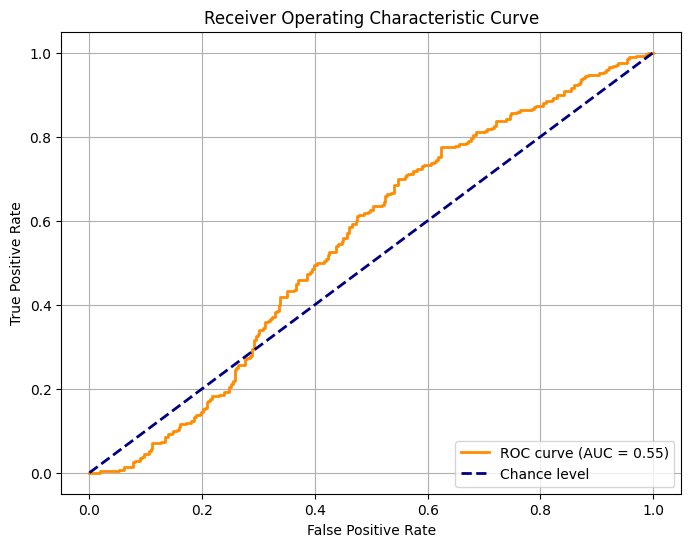

In [176]:
color_anomali = AnomalyDetectionModel(colorization_encoder)

# Finetuning ! 
color_anomali = fine_tune_anomaly_detection(color_anomali, ew_train_loader, ew_test_loader, 10, 1e-3)

scores, labels = color_anomali.evaluate_anomaly_detection(ew_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

Epoch 1/10, Train Loss: 0.0536, Val Loss: 0.0509
Epoch 2/10, Train Loss: 0.0443, Val Loss: 0.0490
Epoch 3/10, Train Loss: 0.0397, Val Loss: 0.0401
Epoch 4/10, Train Loss: 0.0382, Val Loss: 0.0396
Epoch 5/10, Train Loss: 0.0372, Val Loss: 0.0436
Epoch 6/10, Train Loss: 0.0363, Val Loss: 0.0404
Epoch 7/10, Train Loss: 0.0372, Val Loss: 0.0393
Epoch 8/10, Train Loss: 0.0349, Val Loss: 0.0379
Epoch 9/10, Train Loss: 0.0355, Val Loss: 0.0369
Epoch 10/10, Train Loss: 0.0332, Val Loss: 0.0364


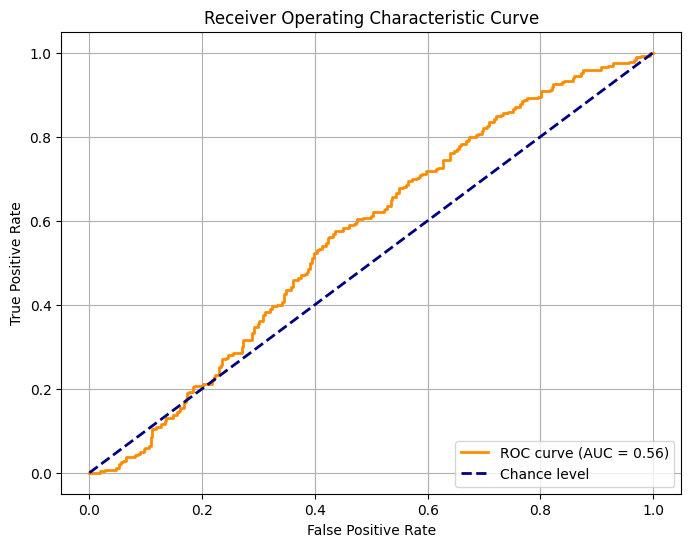

In [193]:
inpainting_anomali = AnomalyDetectionModel(inpainting_encoder)

# Finetuning ! 
history = fine_tune_anomaly_detection(inpainting_anomali, ew_train_loader, ew_test_loader, 10, 1e-3)



scores, labels = inpainting_anomali.evaluate_anomaly_detection(ew_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

Epoch 1/10, Train Loss: 0.0212, Val Loss: 0.0235
Epoch 2/10, Train Loss: 0.0208, Val Loss: 0.0235
Epoch 3/10, Train Loss: 0.0214, Val Loss: 0.0236
Epoch 4/10, Train Loss: 0.0214, Val Loss: 0.0235
Epoch 5/10, Train Loss: 0.0203, Val Loss: 0.0236
Epoch 6/10, Train Loss: 0.0204, Val Loss: 0.0235
Epoch 7/10, Train Loss: 0.0201, Val Loss: 0.0235
Epoch 8/10, Train Loss: 0.0198, Val Loss: 0.0234
Epoch 9/10, Train Loss: 0.0198, Val Loss: 0.0234
Epoch 10/10, Train Loss: 0.0199, Val Loss: 0.0234


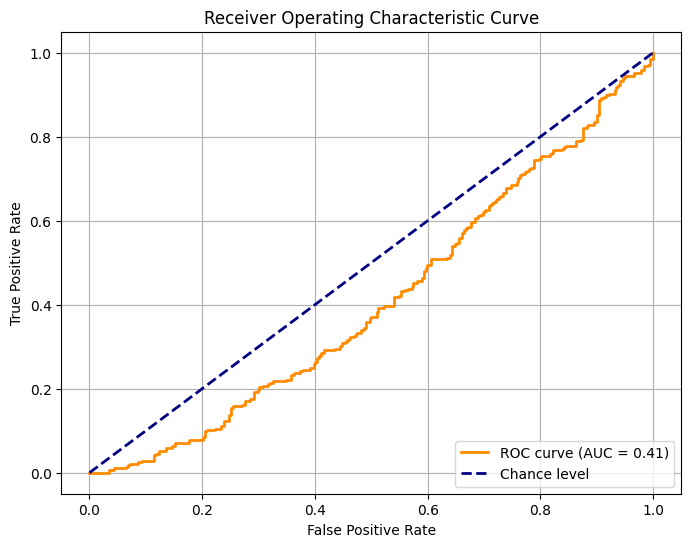

In [49]:
mae_anomali = AnomalyDetectionModel(mae_encoder)

# Finetuning ! 
history = fine_tune_anomaly_detection(mae_anomali, ew_train_loader, ew_test_loader, 10, 1e-5)



scores, labels = mae_anomali.evaluate_anomaly_detection(ew_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)